In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/CEA - CosmoStat/Week 1"
%cd /content/drive/My Drive/CEA - CosmoStat/Week 1

!apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
!pip install plotly tfa-nightly tqdm numpy matplotlib
!pip install rmjarvis.eigency>=1.77.1
!pip install scikit-image
!pip install tensorflow-addons

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'=1.77.1'			  evaluate.py		     __pycache__
 conv2d_svd			  learnlets
 denoising_learned_filter.ipynb   learnlets_vertical.ipynb
/content/drive/My Drive/CEA - CosmoStat/Week 1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libfftw3-dev is already the newest version (3.3.7-1).
python-dev is already the newest version (2.7.15~rc1-1).
libeigen3-dev is already the newest version (3.3.4-4).
pybind11-dev is already the newest version (2.0.1-4).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from learnlets.learnlet_model import Learnlet
from learnlets.keras_utils.normalisation import NormalisationAdjustment
from learnlets.keras_utils.image_tboard_cback import TensorBoardImage
from learnlets.keras_utils.thresholding import DynamicSoftThresholding, DynamicHardThresholding

In [ ]:
plt.rcParams['figure.figsize'] = (9, 5)

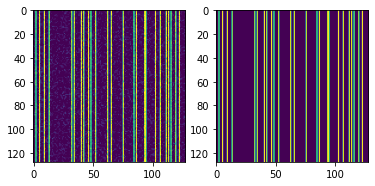

In [ ]:
np.random.seed(seed=10)
noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 8
im_size = 128
prop_bands = 0.2
n_images = 15000
proportion_train_val = 0.8

new_vignets_noiseless = np.zeros((n_images,im_size,im_size))
new_vignets_with_noise = np.zeros((n_images,im_size,im_size))
std = np.zeros((n_images,1))

for it in range(n_images):
  im = np.zeros((im_size, im_size), dtype=np.float64)
  band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
  im[:, band_locations] = 1.0
  new_vignets_noiseless[it,:,:] = im

  if it > proportion_train_val*n_images:
      noise_std_range = (noise_std_val, noise_std_val)
  else: 
      noise_std_range = noise_std_train

  noise_std = tf.random.uniform(
      (1,),
      minval=noise_std_range[0],
      maxval=noise_std_range[1],
  )
  
  noise = tf.random.normal(shape=tf.shape(im), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
  std[it] = noise_std/255
  new_vignets_with_noise[it,:,:] = im+noise

fig, axs = plt.subplots(1, 2)

axs[0].imshow(np.squeeze(new_vignets_with_noise[10,:,:]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(new_vignets_noiseless[10,:,:]), vmin=0, vmax=1)

train_dic = {'VIGNET_NOISELESS':new_vignets_noiseless,'VIGNETS_WITH_NOISE':new_vignets_with_noise,  
             'TRUE_NOISE': std}

In [ ]:
def keras_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1)

def keras_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1)

def center_keras_psnr(y_true, y_pred):
    return tf.image.psnr(_tf_crop(y_true, crop=128), _tf_crop(y_pred, crop=128), 1)

In [ ]:
n_train = int(n_images*proportion_train_val)

im_train, im_val, target_train, target_val = train_test_split(train_dic['VIGNETS_WITH_NOISE'], train_dic['VIGNET_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=1-proportion_train_val, random_state=10)
sigma = train_dic['TRUE_NOISE']
im_train, target_train, sigma[0:n_train] = shuffle(im_train, target_train, sigma[0:n_train])

im_train = (tf.reshape(tf.convert_to_tensor(im_train), [n_train, im_size, im_size, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [n_train, im_size, im_size, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [n_images-n_train, im_size, im_size, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [n_images-n_train, im_size, im_size, 1])
sigma_train = tf.reshape(tf.convert_to_tensor(sigma[0:n_train]), [n_train, 1])
sigma_val = tf.reshape(tf.convert_to_tensor(sigma[n_train:n_images]), [n_images-n_train, 1])

run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 5,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 5,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 3,
    'clip': False,
}

n_epochs = 15

model=Learnlet(**run_params)
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=[keras_psnr, keras_ssim])


Epoch 1/15
200/200 [==============================] - 586s 3s/step - loss: 0.0373 - keras_psnr: 16.4867 - keras_ssim: 0.5914 - val_loss: 0.0076 - val_keras_psnr: 21.1802 - val_keras_ssim: 0.7283
Epoch 2/15
200/200 [==============================] - 585s 3s/step - loss: 0.0072 - keras_psnr: 22.7617 - keras_ssim: 0.7776 - val_loss: 0.0043 - val_keras_psnr: 23.6676 - val_keras_ssim: 0.7878
Epoch 3/15
200/200 [==============================] - 585s 3s/step - loss: 0.0045 - keras_psnr: 25.0339 - keras_ssim: 0.8197 - val_loss: 0.0029 - val_keras_psnr: 25.3382 - val_keras_ssim: 0.8130
Epoch 4/15
200/200 [==============================] - 588s 3s/step - loss: 0.0032 - keras_psnr: 26.6828 - keras_ssim: 0.8409 - val_loss: 0.0022 - val_keras_psnr: 26.5804 - val_keras_ssim: 0.8403
Epoch 5/15
200/200 [==============================] - 590s 3s/step - loss: 0.0023 - keras_psnr: 28.0069 - keras_ssim: 0.8632 - val_loss: 0.0018 - val_keras_psnr: 27.5014 - val_keras_ssim: 0.8559
Epoch 6/15
200/200 [=====

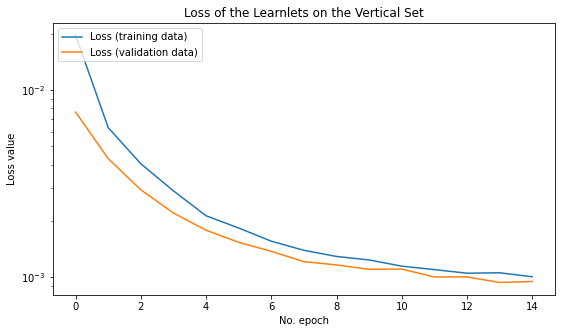

In [ ]:
history = model.fit((im_train, sigma_train), target_train, steps_per_epoch=200, epochs=n_epochs, validation_data=((im_val, sigma_val), target_val), batch_size=batch_size)

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the Learnlets on the Vertical Set')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Model: "learnlet"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
learnlet_analysis (LearnletAnalysis)                  multiple                                        2025              
________________________________________________________________________________________________________________________
scales_threshold (ScalesThreshold)                    multiple                                        90                
________________________________________________________________________________________________________________________
learnlet_synthesis (LearnletSynthesis)                multiple                                        2125              
Total params: 4,240
Trainable params: 4,130
Non-trainable params: 110
_________________________________________________________________

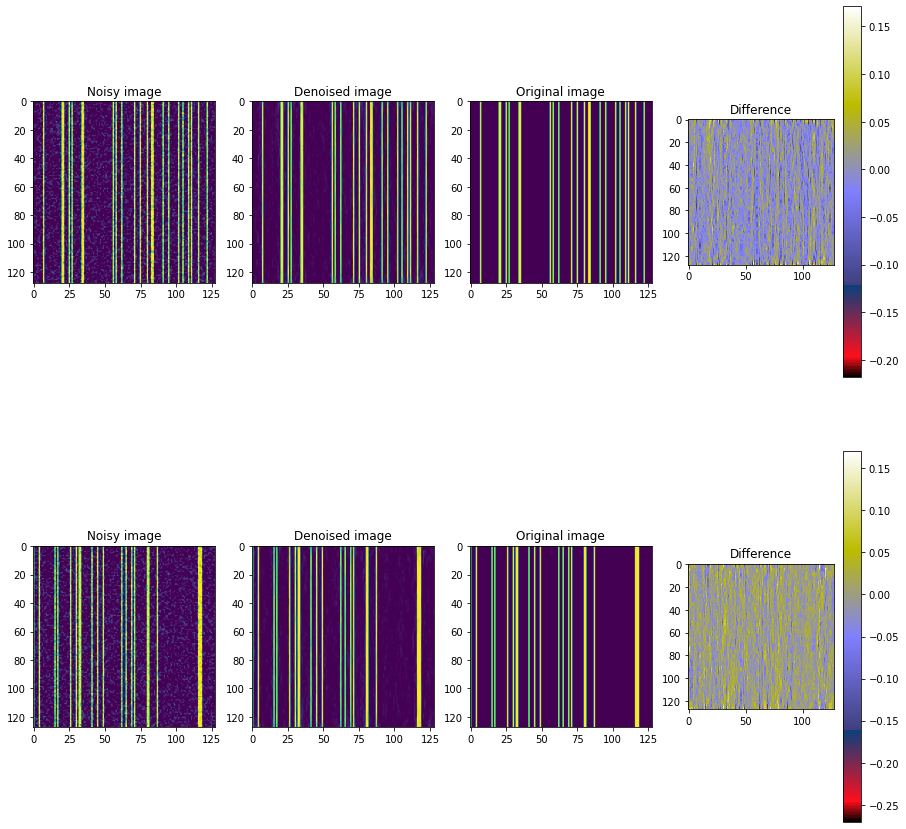

In [ ]:
print(model.summary(line_length=120))

one_vertical_noiseless = tf.reshape(model.predict((im_val, sigma_val))[179,:,:], [im_size, im_size])
one_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[179,:,:]), [im_size, im_size])
one_vertical_noiseless = tf.cast(one_vertical_noiseless, one_vertical_truth.dtype)
one_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[179,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.reshape(model.predict((im_val, sigma_val))[181,:,:], [im_size, im_size])
second_vertical_truth = tf.reshape(tf.convert_to_tensor(target_val[181,:,:]), [im_size, im_size])
second_vertical_noiseless = tf.cast(second_vertical_noiseless, second_vertical_truth.dtype)
second_vertical_noise = tf.reshape(tf.convert_to_tensor(im_val[181,:,:]), [im_size, im_size])


fig = plt.figure(num=0, figsize=(15,15))
plt.subplot(241)
plt.title('Noisy image')
plt.imshow(one_vertical_noise, vmin=0, vmax=1);
plt.subplot(242)
plt.imshow(one_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(243)
plt.title('Original image')
plt.imshow(one_vertical_truth, vmin=0, vmax=1);
plt.subplot(244)
plt.title('Difference')
plt.imshow(one_vertical_noiseless-one_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.subplot(245)
plt.title('Noisy image')
plt.imshow(second_vertical_noise, vmin=0, vmax=1);
plt.subplot(246)
plt.imshow(second_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(247)
plt.title('Original image')
plt.imshow(second_vertical_truth, vmin=0, vmax=1);
plt.subplot(248)
plt.title('Difference')
plt.imshow(second_vertical_noiseless-second_vertical_truth, interpolation='None',cmap='gist_stern');plt.colorbar()
plt.show()

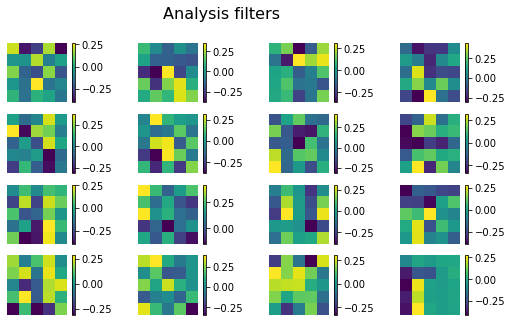

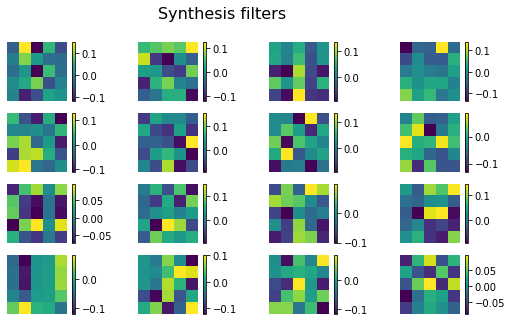

In [ ]:
analysis_kernels = np.zeros((5,5,5,1,16))
synthesis_kernels = np.zeros((5,5,5,17,1))
for i in range(5):
  analysis_kernels[i] = np.copy(model.layers[0].get_weights()[i])
  synthesis_kernels[i] = np.copy(model.layers[2].get_weights()[i])
base_f = 4

save_analysis_kernels = model.layers[0].get_weights()[:]

fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(analysis_kernels[0,:,:, 0, i * base_f + j]))
    axs[i, j].axis('off')
    fig.colorbar(im, ax=axs[i, j])
fig.suptitle('Analysis filters', fontsize=16)

fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(synthesis_kernels[0,:,:, i * base_f + j, 0]))
    axs[i, j].axis('off')
    fig.colorbar(im, ax=axs[i, j])
fig.suptitle('Synthesis filters', fontsize=16)
plt.show()

In [ ]:
# The idea of this part is to store the original trained kernels. In that way, 
# different threshold values can be tested without needing to run the whole notebook again

#analysis_backup = np.copy(analysis_kernels)
analysis_kernels = np.copy(analysis_backup)

In [ ]:
# Same as the previous cell, but for the synthesis filters.

#save_synthesis_kernels = np.copy(synthesis_kernels)
synthesis_kernels = np.copy(save_synthesis_kernels)

In [ ]:
def SingularValues(kernel, input_size, type):
    #transform = tf.signal.fft2d(kernel, input_size)

    s, u, v = tf.linalg.svd(kernel)
    s_n = s.numpy()
    if type=='threshold':
      thr = 0.5*s_n[0]
      s=tf.convert_to_tensor(np.where(s < thr, 0, s))
    elif type=='two_max':
      s = np.array([s_n[0], s_n[1], 0, 0, 0])
    elif type=='three_max':
      s = np.array([s_n[0], s_n[1], s_n[2], 0, 0])
    return tf.matmul(u,tf.matmul(np.diag(s),v,adjoint_b=True))

In [ ]:
for i in range(5):
  for j in range(16):
    analysis_kernels[i,:,:,0,j] = SingularValues(analysis_kernels[i,:,:,0,j], im_size, 'threshold')
  save_analysis_kernels[i] = analysis_kernels[i]
  
model.layers[0].set_weights(save_analysis_kernels)

In [ ]:
for i in range(5):
  for j in range(17):
    synthesis_kernels[i,:,:,j,0] = SingularValues(synthesis_kernels[i,:,:,j,0], im_size, 'threshold')

model.layers[2].set_weights(synthesis_kernels)

In [ ]:
metrics = model.evaluate((im_train, sigma_train), target_train, steps=300)

300/300 [==============================] - 1048s 3s/step - loss: 0.0028 - keras_psnr: 25.6436 - keras_ssim: 0.8377


## Results (loss='mse' values)

| SV Kept/Kernel | Analysis | Synthesis | Both |
| :- | -: | :-: | :-: |
| Unmodified | 0.0012 | 0.0012 | 0.0012
| 0.05$\sigma_{max}$ | 0.0012 | 0.0012 | -
| 0.1$\sigma_{max}$ | 0.0012 | 0.0013 | 0.0013
| 0.15$\sigma_{max}$ | 0.0012 | 0.0015 | -
| 0.2$\sigma_{max}$ | 0.0014 | 0.0019 | 0.0018
| 0.3$\sigma_{max}$ | 0.0017 | 0.0023 | 0.0027
| 0.4$\sigma_{max}$ | 0.0028 | 0.0029 | -
| 0.5$\sigma_{max}$ | 0.0054 | 0.0040 | 0.0093
| 0.75$\sigma_{max}$ | 0.0145 | 0.0098 | -
| 0.8$\sigma_{max}$ | 0.0133 | 0.0109 | -
| 0.9$\sigma_{max}$ | 0.0122 | 0.0114 | -



| SV Kept/Kernel | Analysis | Synthesis | Both |
| :- | -: | :-: | :-: |
| Unmodified | 0.0012 | 0.0012 | 0.0012
| $\sigma_{max}$ only | 0.1160 | 0.1438 | -
| Two highest $\sigma$ | 0.0047 | 0.0065 | 0.0119
| Three highest $\sigma$ | 0.0023 | 0.0050 | 0.0053

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


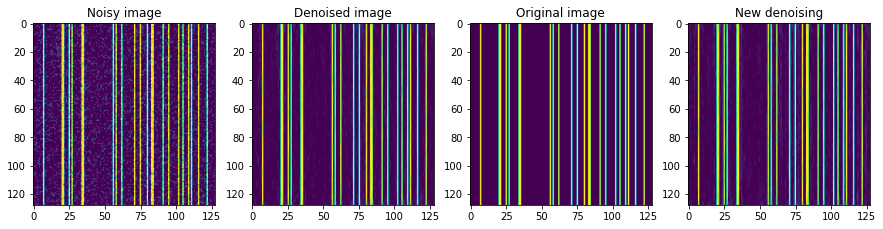

In [ ]:
one_new_vertical_noiseless = tf.reshape(model.predict((im_val, sigma_val))[179,:,:], [im_size, im_size])

print(type(one_new_vertical_noiseless))
print(type(one_vertical_truth))
fig = plt.figure(num=0, figsize=(15,15))
plt.subplot(241)
plt.title('Noisy image')
plt.imshow(one_vertical_noise, vmin=0, vmax=1);
plt.subplot(242)
plt.imshow(one_vertical_noiseless, vmin=0, vmax=1);
plt.title('Denoised image')
plt.subplot(243)
plt.title('Original image')
plt.imshow(one_vertical_truth, vmin=0, vmax=1);
plt.subplot(244)
plt.title('New denoising')
plt.imshow(one_new_vertical_noiseless, vmin=0, vmax=1);
plt.show()